# Example Comparison Code

In [15]:
import numpy as np
import json
import os
import drjit as dr
import mitsuba as mi
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from Py6S import *

mi.set_variant("llvm_ad_rgb_double")

In [16]:
red='#E06666'
green='#9DBB53'
blue='#78C7FF'

In [17]:
def relative_diff(a, b):
    return (a - b) / b

def simple_diff(a, b):
    return a - b

def abs_diff(a, b):
    return np.abs(a - b)

def sph_to_eucl(theta, phi):
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

In [18]:
# Ocean parameters
wavelength = 2.2
wind_speed = 4
wind_direction = 0
salinity = 34.3
pigmentation = 0.3

# Set up the solar zenith angle
solar_zenith = 45
solar_azimuth = 0

outgoing_zeniths = np.arange(0, 90, 1)
outgoing_azimuth = 180

In [19]:
# SixS Simulation
s = SixS()
s.aero_profile = AeroProfile.PredefinedType(AeroProfile.NoAerosols)
s.atmos_profile = AtmosProfile.PredefinedType(AtmosProfile.NoGaseousAbsorption)
s.ground_reflectance = GroundReflectance.HomogeneousOcean(wind_speed, wind_direction, salinity, pigmentation)

# Use a relatively small offet to avoid numerical issues with the SixS model... 
s.wavelength = Wavelength(wavelength)

results = {}
total_reflectance = {}
foam_values = {}
glint_values = {}
water_values = {}
foam_percentages = {}
glint_percentages = {}
water_percentages = {}
idx = 0
max_idx = len(outgoing_zeniths)

# Run simulations for every viewing zenith
for viewing_zenith in outgoing_zeniths:
    s.geometry = Geometry.User()
    s.geometry.solar_z = solar_zenith
    s.geometry.solar_a = solar_azimuth
    s.geometry.view_z = viewing_zenith
    s.geometry.view_a = outgoing_azimuth
    s.run()

    foam = s.outputs.values['water_component_foam']
    glint = s.outputs.values['water_component_glint']
    water = s.outputs.values['water_component_water']
    total = foam + glint + water
    foam_percent = foam / total
    glint_percent = glint / total
    water_percent = water / total
    total_reflectance[viewing_zenith] = total
    results[viewing_zenith] = [foam, glint, water]
    if total < 1e-6:
        foam = 0
        glint = 0
        water = 0
        foam_percent = 0
        glint_percent = 0
        water_percent = 0
    else:
        foam_values[viewing_zenith] = foam
        glint_values[viewing_zenith] = glint
        water_values[viewing_zenith] = water
        foam_percentages[viewing_zenith] = foam_percent
        glint_percentages[viewing_zenith] = glint_percent
        water_percentages[viewing_zenith] = water_percent

    idx += 1
    print(f'    Foam: {foam}, Glint: {glint}, Water: {water}')
    print(f"Completed {idx}/{max_idx}")

outgoing_reflectances = []
foam = []
glint = []
water = []
for zenith in outgoing_zeniths:
    outgoing_reflectances.append(total_reflectance[zenith])
    foam.append(foam_values[zenith])
    glint.append(glint_values[zenith])
    water.append(water_values[zenith])

outgoing_reflectances = np.array(outgoing_reflectances)
foam = np.array(foam)
glint = np.array(glint)
water = np.array(water)

    Foam: 3e-05, Glint: 0.00092, Water: 0.0
Completed 1/90
    Foam: 3e-05, Glint: 0.00118, Water: 0.0
Completed 2/90
    Foam: 3e-05, Glint: 0.00149, Water: 0.0
Completed 3/90
    Foam: 3e-05, Glint: 0.00187, Water: 0.0
Completed 4/90
    Foam: 3e-05, Glint: 0.00233, Water: 0.0
Completed 5/90
    Foam: 3e-05, Glint: 0.00288, Water: 0.0
Completed 6/90
    Foam: 3e-05, Glint: 0.00355, Water: 0.0
Completed 7/90
    Foam: 3e-05, Glint: 0.00435, Water: 0.0
Completed 8/90
    Foam: 3e-05, Glint: 0.0053, Water: 0.0
Completed 9/90
    Foam: 3e-05, Glint: 0.00643, Water: 0.0
Completed 10/90
    Foam: 3e-05, Glint: 0.00776, Water: 0.0
Completed 11/90
    Foam: 3e-05, Glint: 0.00934, Water: 0.0
Completed 12/90
    Foam: 3e-05, Glint: 0.01121, Water: 0.0
Completed 13/90
    Foam: 3e-05, Glint: 0.0134, Water: 0.0
Completed 14/90
    Foam: 3e-05, Glint: 0.01598, Water: 0.0
Completed 15/90
    Foam: 3e-05, Glint: 0.019, Water: 0.0
Completed 16/90
    Foam: 3e-05, Glint: 0.02254, Water: 0.0
Completed

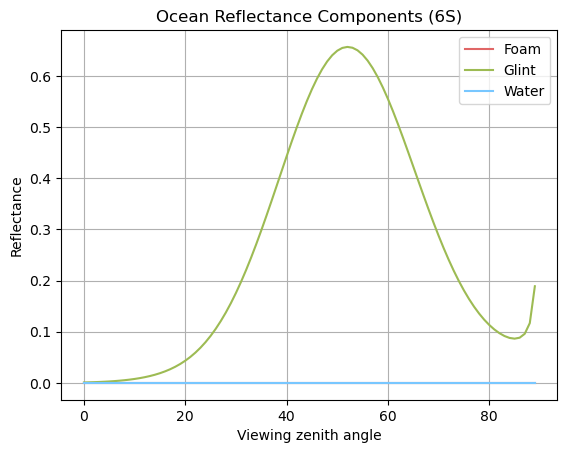

In [20]:
# Plot the results
import matplotlib.pyplot as plt

visualization_index = 0

# Plot the reflectance components in red, green and blue
plt.plot(outgoing_zeniths, foam, color=red)
plt.plot(outgoing_zeniths, glint, color=green)
plt.plot(outgoing_zeniths, water, color=blue)

plt.xlabel('Viewing zenith angle')
plt.ylabel('Reflectance')
plt.title('Ocean Reflectance Components (6S)')
plt.legend(['Foam', 'Glint', 'Water', 'Total'])
plt.grid()
plt.show()


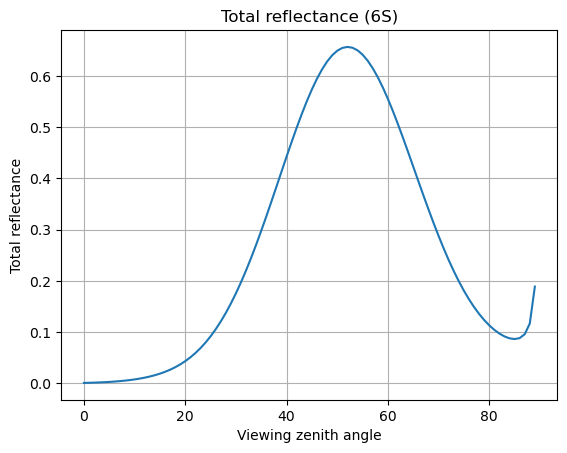

In [21]:
# Plot the total reflectance
plt.plot(outgoing_zeniths, [total_reflectance[zenith] for zenith in outgoing_zeniths])

plt.xlabel('Viewing zenith angle')
plt.ylabel('Total reflectance')
plt.title('Total reflectance (6S)')
plt.grid()
plt.show()

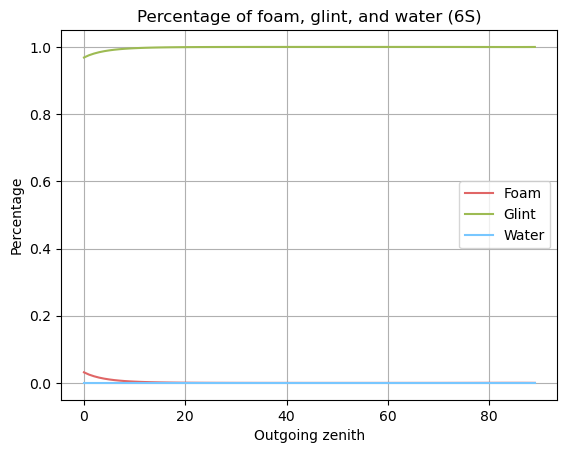

In [22]:
# Percentage of foam, glint, and water
fig, ax = plt.subplots()

foam_percent_data = foam_percentages.values()
glint_percent_data = glint_percentages.values()
water_percent_data = water_percentages.values()

ax.plot(outgoing_zeniths, foam_percent_data, label='Foam', color=red)
ax.plot(outgoing_zeniths, glint_percent_data, label='Glint', color=green)
ax.plot(outgoing_zeniths, water_percent_data, label='Water', color=blue)

ax.set(xlabel='Outgoing zenith', ylabel='Percentage',
            title=f'Percentage of foam, glint, and water (6S)')
ax.grid()
plt.legend()
plt.show()


In [23]:
WHITECAP=0
GLINT=1
UNDERLIGHT=2
TOTAL=3

channels = [WHITECAP, GLINT, UNDERLIGHT, TOTAL]

2024-07-25 17:04:27 WARN main [oceanic_legacy.cpp:236] Effective reflectance: [0.065]

2024-07-25 17:04:28 WARN main [oceanic_legacy.cpp:237] Whitecap reflectance: [2.5234e-05]

2024-07-25 17:04:28 WARN main [oceanic_legacy.cpp:236] Effective reflectance: [0.065]

2024-07-25 17:04:28 WARN main [oceanic_legacy.cpp:237] Whitecap reflectance: [2.5234e-05]

2024-07-25 17:04:28 WARN main [oceanic_legacy.cpp:236] Effective reflectance: [0.065]

2024-07-25 17:04:28 WARN main [oceanic_legacy.cpp:237] Whitecap reflectance: [2.5234e-05]

2024-07-25 17:04:28 WARN main [oceanic_legacy.cpp:236] Effective reflectance: [0.065]

2024-07-25 17:04:28 WARN main [oceanic_legacy.cpp:237] Whitecap reflectance: [2.5234e-05]

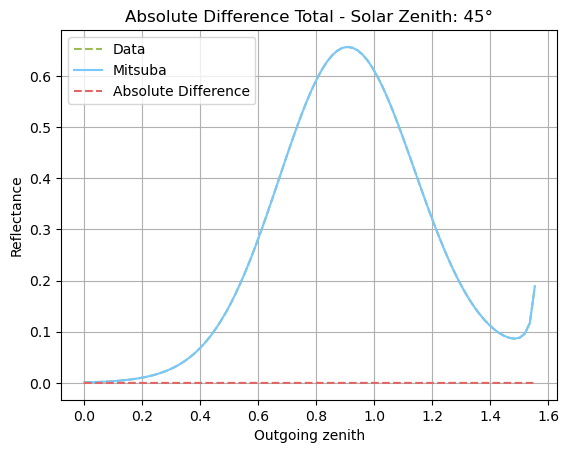

In [24]:
brdf_values = None
brdf_foam = None
brdf_glint = None
brdf_underlight = None

# Create a dummy surface interaction to use for the evaluation of the BSDF
si = dr.zeros(mi.SurfaceInteraction3f)

# Specify an incident direction with X degrees
si.wi = sph_to_eucl(np.deg2rad(solar_zenith), dr.deg2rad(0))

# Create grid in spherical coordinates and map it into a sphere
resolution = len(outgoing_zeniths)
zeniths_o, azimuths_o = dr.meshgrid(
    dr.linspace(mi.Float, np.deg2rad(0), np.deg2rad(89), resolution),

    # Data was generated with a viewing azimuth of π radians
    dr.linspace(mi.Float, np.pi, np.pi, 1)
)
wo = sph_to_eucl(zeniths_o, azimuths_o)

for channel in channels:
    bsdf = mi.load_dict({
        'type': 'oceanic_legacy',
        'channel': channel,
        'wavelength': wavelength,
        'wind_speed': wind_speed,
        'wind_direction': wind_direction,
        'chlorinity': 19,
        'pigmentation': 0.3
    })
    
    #result = bsdf.eval(mi.BSDFContext(), si, wo)
    if channel == WHITECAP:
        brdf_foam = bsdf.eval(mi.BSDFContext(), si, wo)
    elif channel == GLINT:
        brdf_glint = bsdf.eval(mi.BSDFContext(), si, wo)
    elif channel == UNDERLIGHT:
        brdf_underlight = bsdf.eval(mi.BSDFContext(), si, wo)
    elif channel == TOTAL:
        brdf_values = bsdf.eval(mi.BSDFContext(), si, wo)

# Evaluate the BSDF
bsdf_array = np.array(brdf_values)
foam_array = np.array(brdf_foam)
glint_array = np.array(brdf_glint)
underlight_array = np.array(brdf_underlight)

# Extract one channel
bsdf_array = bsdf_array[:, 0]
foam_array = foam_array[:, 0]
glint_array = glint_array[:, 0]
underlight_array = underlight_array[:, 0]

# Compute the difference between the data and the Mitsuba BSDF
reflectance_diff = abs_diff(outgoing_reflectances, bsdf_array)
foam_diff = abs_diff(foam, foam_array)
glint_diff = abs_diff(glint, glint_array)
underlight_diff = abs_diff(water, underlight_array)

# Plot against the outgoing zeniths
fig, ax = plt.subplots()
im = ax.plot(zeniths_o, outgoing_reflectances, label='Data', linestyle='--', color=green)
im = ax.plot(zeniths_o, bsdf_array, label='Mitsuba', linestyle='-', color=blue)
im = ax.plot(zeniths_o, reflectance_diff, label='Absolute Difference', linestyle='--', color=red)
ax.set(xlabel='Outgoing zenith', ylabel='Reflectance',
         title=f'Absolute Difference Total - Solar Zenith: {solar_zenith}°')
ax.grid()
ax.legend()
plt.show()

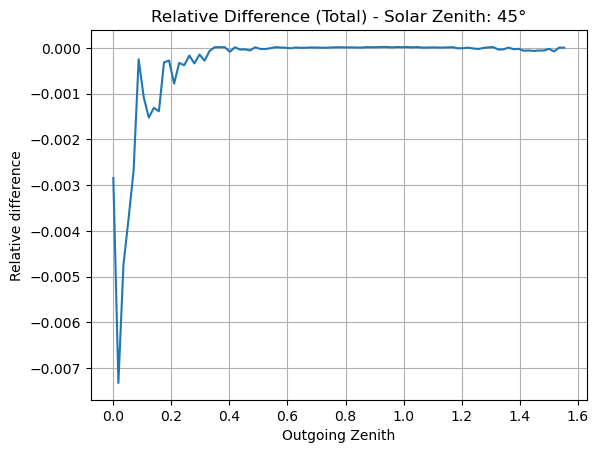

In [25]:
# Relative difference 
relative_diffs = relative_diff(bsdf_array, outgoing_reflectances)

fig, ax = plt.subplots()
im = ax.plot(zeniths_o, relative_diffs)
ax.set(xlabel='Outgoing Zenith', ylabel='Relative difference',
         title=f'Relative Difference (Total) - Solar Zenith: {solar_zenith}°')
ax.grid()
plt.show()

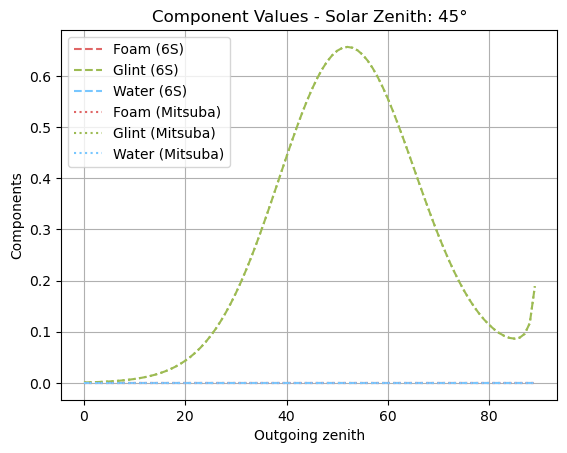

In [26]:
# Component-wise comparison of the BSDF
fig, ax = plt.subplots()

# Plot example foam, glint and underlight with dashed lines
im = ax.plot(outgoing_zeniths, foam, label='Foam (6S)', linestyle='--', color=red)
im = ax.plot(outgoing_zeniths, glint, label='Glint (6S)', linestyle='--', color=green)
im = ax.plot(outgoing_zeniths, water, label='Water (6S)', linestyle='--', color=blue)

# Plot the Mitsuba foam, glint and underlight with dotted lines
im = ax.plot(outgoing_zeniths, foam_array, label='Foam (Mitsuba)', linestyle=':', color=red)
im = ax.plot(outgoing_zeniths, glint_array, label='Glint (Mitsuba)', linestyle=':', color=green)
im = ax.plot(outgoing_zeniths, underlight_array, label='Water (Mitsuba)', linestyle=':', color=blue)

# Plot metadata
ax.set(xlabel='Outgoing zenith', ylabel='Components',
            title=f'Component Values - Solar Zenith: {solar_zenith}°')
ax.legend()
ax.grid()
plt.show()

/var/folders/2y/rhmx4lpx7yj6c8p50ldw1x_c0000gp/T/ipykernel_58859/2444709021.py:2: RuntimeWarning: invalid value encountered in divide
  return (a - b) / b


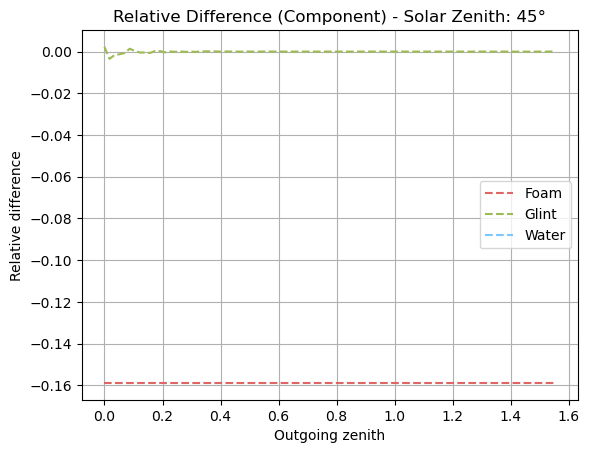

In [27]:
relative_foam_diffs = relative_diff(foam_array, foam)
relative_glint_diffs = relative_diff(glint_array, glint)
relative_underlight_diffs = relative_diff(underlight_array, water)

fig, ax = plt.subplots()

# Plot example foam, glint and underlight with dashed lines
im = ax.plot(zeniths_o, relative_foam_diffs, label='Foam', linestyle='--', color=red)
im = ax.plot(zeniths_o, relative_glint_diffs, label='Glint', linestyle='--', color=green)
im = ax.plot(zeniths_o, relative_underlight_diffs, label='Water', linestyle='--', color=blue)

# Plot metadata
ax.set(xlabel='Outgoing zenith', ylabel='Relative difference',
            title=f'Relative Difference (Component) - Solar Zenith: {solar_zenith}°')
ax.legend()
ax.grid()
plt.show()

In [32]:
# Relative Difference Metrics
print(f'Mean Scores:')
print(f"    Mean relative difference (Total): {np.mean(relative_diffs)}")
print(f"    ========================================================")
print(f"    Mean relative difference (Foam): {np.mean(relative_foam_diffs)}")
print(f"    Mean relative difference (Glint): {np.mean(relative_glint_diffs)}")
print(f"    Mean relative difference (Underlight): {np.mean(relative_underlight_diffs)}")

Mean Scores:
    Mean relative difference (Total): -0.0003370626825526259
    Mean relative difference (Foam): -0.15886584366170828
    Mean relative difference (Glint): -3.532859036601382e-05
    Mean relative difference (Underlight): nan
